In [1]:
import sys

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers
from tensorflow.python.framework.errors_impl import NotFoundError

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

from src.cfd import CFD
from src.gauss_hist import get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results

In [2]:
N_JOBS = 8

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

N_BASELINE = 8

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

In [4]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Utils

In [5]:
model_name = 'UNet'


def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x


def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x


def create_model():
    inputs = layers.Input(24)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 64)
    skip2, x = conv_block(x, 128)
    skip3, x = conv_block(x, 256)
    x, _ = conv_block(x, 512)

    x = deconv_block(x, skip3, 256)
    x = deconv_block(x, skip2, 128)
    x = deconv_block(x, skip1, 64)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model


def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(np.arange(24), y, a_0=1, std_0=1.)

    return y_pred

In [6]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=0.0005, train=False, n_epochs=3000, verbose=1,
                batch_size=4096, lr_patience=20, es_patience=50, loss_weights=10000):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_all', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, loss_weights, root=PWD)

In [7]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

# Load optimal CFD thresholds

In [8]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.170
(1, 11): 0.175
(2,  2): 0.230
(2, 11): 0.145
(3,  2): 0.140
(3, 11): 0.165


# Train the network

In [9]:
train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
for (plane, channel), (X, y) in dataset.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    train_X_list.append(X_train)
    train_y_list.append(Y_heatmap_train)
    test_X_list.append(X_test)
    test_y_list.append(Y_heatmap_test)

X_train_all = np.concatenate(train_X_list)
y_train_all = np.concatenate(train_y_list)
X_test_all = np.concatenate(test_X_list)
y_test_all = np.concatenate(test_y_list)

X_train_all.shape, y_train_all.shape, X_test_all.shape, y_test_all.shape

((94174, 24), (94174, 24), (31394, 24), (31394, 24))

In [10]:
model = create_model()
history = train_model(model, model_name, X_train=X_train_all, y_train=y_train_all, X_val=X_test_all, y_val=y_test_all,
                      train=False)

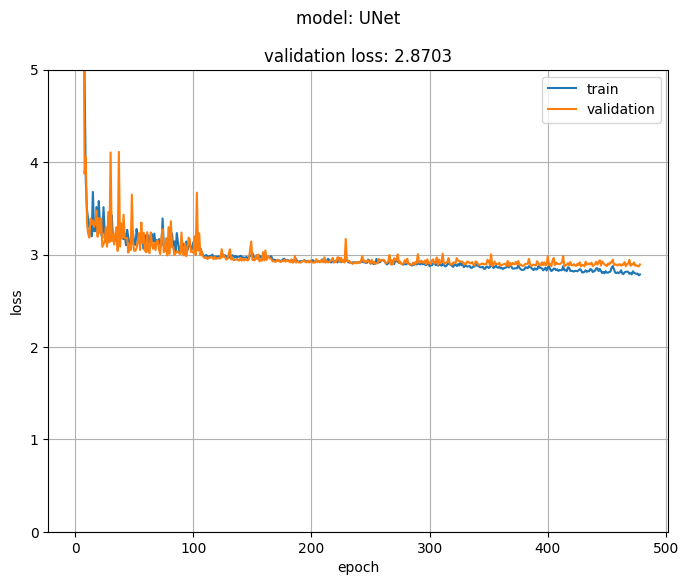

In [11]:
plot_history(history, f'model: {model_name}', ymax=5)

# Test

Processing p=1, ch=2...
1/1 [==============================] - 3s 3s/step
       CFD: 75.42 ps
      UNet: 69.66 ps (improvement: 7.64 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 94ms/step
       CFD: 87.28 ps
      UNet: 80.55 ps (improvement: 7.71 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 238ms/step
       CFD: 78.14 ps
      UNet: 68.17 ps (improvement: 12.76 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 97ms/step
       CFD: 89.47 ps
      UNet: 84.31 ps (improvement: 5.77 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 397ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 87.37 ps
      UNet: 77.85 ps (improvement: 10.90 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 98ms/step
       CFD: 112.05 ps
      UNet: 91.93 ps (improvement: 17.95 %)


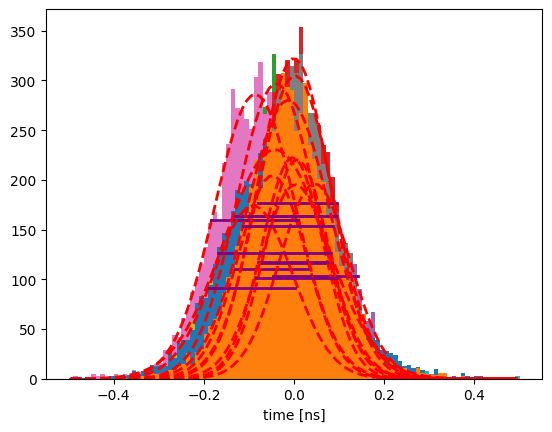

In [12]:
improvements = {}
for (plane, channel), (all_X, all_y) in dataset.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(x_time, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], [model_name], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [13]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  75.42 ps, NN:  69.66 ( 7.64 %)
(1, 11) CFD:  87.28 ps, NN:  80.55 ( 7.71 %)
(2,  2) CFD:  78.14 ps, NN:  68.17 (12.76 %)
(2, 11) CFD:  89.47 ps, NN:  84.31 ( 5.77 %)
(3,  2) CFD:  87.37 ps, NN:  77.85 (10.90 %)
(3, 11) CFD: 112.05 ps, NN:  91.93 (17.95 %)
